# Android app stats

> May I ask if you could help me out with some (June 2019) data in this Gdoc? I’m currently working on figuring out next steps on how to increase reach/engagement for ”Suggested edits”. This data would really help to set goals and to measure impact.

In [1]:
library(glue)
library(zeallot)
library(magrittr)
import::from(dplyr, group_by, summarize, ungroup, mutate, select, arrange, keep_where = filter, rename, count, pull)
import::from(tidyr, spread, gather)
import::from(polloi, compress)
options(digits = 2)

# Intelligently figure out the year & month to calculate stats for:
today <- lubridate::today()
beginning_of_curr_month <- lubridate::floor_date(today, "month")
last_day_of_prev_month <- beginning_of_curr_month - 1
year <- lubridate::year(last_day_of_prev_month)
month <- lubridate::month(last_day_of_prev_month)

# Set up organization for data:
yyyy_mm <- sprintf("%.0f-%02.0f", year, month)
data_dir <- file.path("data", yyyy_mm)

cat(glue("Report to be generated for {month.name[month]} {year}"))

Report to be generated for June 2019

## Overall stats

- Total number of unique users that have set multiple languages in the app
- Total number of unique users that have been logged in to Wikipedia in the app

In [2]:
daily_stats <- readr::read_csv(file.path(data_dir, "daily_stats.csv.gz"), col_types = "clciil")

In [3]:
head(daily_stats)

app_install_id,is_anon,languages,days_installed,n_languages,multilang
<chr>,<lgl>,<chr>,<int>,<int>,<lgl>
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,TRUE,"[""ru""]",330,1,FALSE
0000079c-dc39-4595-a915-db1498ee239b,TRUE,"[""pt""]",966,1,FALSE
00000b0c-cfea-4866-a6e8-9ab37de4d7ac,TRUE,"[""en""]",981,1,FALSE
00000ce8-4583-47e8-ab10-b4b8107c836f,TRUE,"[""en""]",516,1,FALSE
00000e5a-98d1-49bc-868f-cf5f2f30c4ff,TRUE,"[""es""]",656,1,FALSE
00001144-142b-44fb-acaf-917adee89b7e,TRUE,"[""en""]",695,1,FALSE


In [4]:
# Compute stats for the metrics table at the end:
multilang_stat <- daily_stats %>%
    count(multilang) %>%
    spread(multilang, n) %>%
    mutate(prop = `TRUE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`TRUE`, 1), compress(`TRUE` + `FALSE`, 1))) %>%
    pull(summarized)

anon_stat <- daily_stats %>%
    count(is_anon) %>%
    spread(is_anon, n) %>%
    mutate(prop = `TRUE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`TRUE`, 1), compress(`TRUE` + `FALSE`, 1))) %>%
    pull(summarized)

loggedin_stat <- daily_stats %>%
    count(is_anon) %>%
    spread(is_anon, n) %>%
    mutate(prop = `FALSE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`FALSE`, 1), compress(`TRUE` + `FALSE`, 1))) %>%
    pull(summarized)

c("multilingual" = multilang_stat, "anon" = anon_stat, "logged-in" = loggedin_stat)

multilingual                        anon 
 "25.9% (1.1M out of 4.2M)"    "95.0% (4M out of 4.2M)" 
                  logged-in 
"5.0% (207.8K out of 4.2M)"

## Session length

- Average session time per user
- Total number of unique users who were at least on one article page

In [5]:
session_summaries <- data.table::fread(paste("zcat", file.path(data_dir, "session_summaries.csv.gz")), key = c("app_install_id", "date"))
session_summaries$reading_user <- session_summaries$n_reading_sessions > 0

Taking input= as a system command ('zcat data/2019-06/session_summaries.csv.gz') and a variable has been used in the expression passed to `input=`. Please use fread(cmd=...). There is a security concern if you are creating an app, and the app could have a malicious user, and the app is not running in a secure envionment; e.g. the app is running as root. Please read item 5 in the NEWS file for v1.11.6 for more information and for the option to suppress this message.


In [6]:
head(session_summaries)

app_install_id,n_total_sessions,n_reading_sessions,total_session_length,total_reading_length,n_languages,date,reading_user
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,1,1,548,548,1,2019-06-04,TRUE
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,1,1,76,76,1,2019-06-19,TRUE
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,2,2,453,453,1,2019-06-25,TRUE
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,1,1,77,77,1,2019-06-26,TRUE
00000086-3080-4cf6-8ed8-9e91d7c0b7fc,1,1,916,916,1,2019-06-29,TRUE
0000079c-dc39-4595-a915-db1498ee239b,8,0,0,0,1,2019-06-01,FALSE


In [7]:
dau <- session_summaries[, list(n_users = .N), by = "date"]
ceiling(mean(dau$n_users))

[1] 2324316

In [8]:
mau <- session_summaries[, list(n_users = length(unique(app_install_id))),]$n_users
mau

[1] 4519789

In [9]:
avg_session_time <- mean(session_summaries$total_session_length / session_summaries$n_total_sessions) %>%
    round %>%
    lubridate::seconds_to_period() %>%
    tolower
avg_session_time

[1] "1m 19s"

In [10]:
readers_monthly <- session_summaries[, list(reading_user = any(reading_user)), by = "app_install_id"][, list(n = .N), by = "reading_user"] %>%
    as.data.frame() %>%
    spread(reading_user, n) %>%
    mutate(prop = `TRUE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`TRUE`, 1), compress(`TRUE` + `FALSE`, 1))) %>%
    pull(summarized)
readers_monthly

[1] "71.5% (3.2M out of 4.5M)"

In [11]:
readers_daily <- session_summaries[, list(n = .N), by = c("date", "reading_user")] %>%
    as.data.frame() %>%
    spread(reading_user, n) %>%
    summarize(`TRUE` = mean(`TRUE`), `FALSE` = mean(`FALSE`)) %>%
    mutate(prop = `TRUE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`TRUE`, 1), compress(`TRUE` + `FALSE`, 1))) %>%
    pull(summarized)
readers_daily

[1] "25.5% (593.7K out of 2.3M)"

## Reading

Average session time of users on an article page

In [12]:
reading_time <- readr::read_csv(file.path(data_dir, "reading_time.csv"), col_types = "cd")

In [13]:
head(reading_time)

app_install_id,avg_reading_time
<chr>,<dbl>
0011975e-36b1-4061-a198-264dda5b6fca,1.8
001f2431-5624-469d-988e-b595039233d6,59.0
00208159-3092-4df1-9ebb-e2058aa5f872,4.3
00210a6f-fc87-412d-bdaf-a99b668019a4,309.0
00217cf6-965b-4178-8b7f-f8cc29c3b157,1.7
0027e82b-f744-48ef-9def-5b1c4464f823,2.5


In [14]:
library(ggplot2)

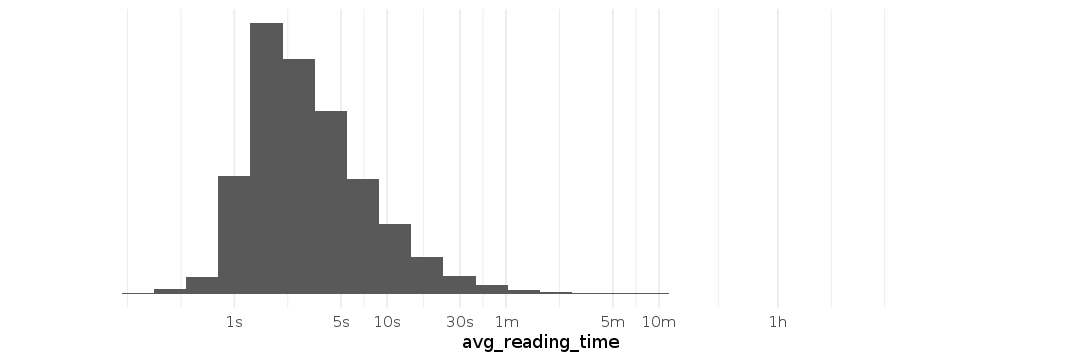

In [15]:
options(repr.plot.width = 9, repr.plot.height = 3)
reading_time %>%
    keep_where(avg_reading_time > 0) %>%
    ggplot(aes(x = avg_reading_time)) +
    geom_histogram(bins = 30) +
    scale_x_log10(label = function(x) {
        y <- tolower(lubridate::seconds_to_period(round(x)))
        z <- gsub(" 0[hms]", "", y)
        return(z)
    }, breaks = c(1, 5, 10, 30, 60, 300, 600, 3600)) +
    scale_y_continuous(name = NULL, breaks = NULL, minor_breaks = NULL) +
    theme_minimal()

## Edits

- Total number of unique users that have made an edit
- Average session time of users that made an edit

In [16]:
edit_session_summaries <- readr::read_csv(file.path(data_dir, "edit_session_summaries.csv"), col_types = "ccclllD")

In [17]:
head(edit_session_summaries)

app_install_id,edit_session_token,edit_type,is_anon,edit_save_attempted,edit_session_completed,date
<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<date>
00115b36-b38f-49e6-b7a9-2532784d9be5,eec0435b-567b-4394-b34e-559a49fbe843,article,TRUE,FALSE,FALSE,2019-06-01
003b3df5-54a6-4a35-9561-44ed6eaa8371,cc1e068e-1b74-4188-975b-137935291d8d,article,TRUE,FALSE,FALSE,2019-06-01
00436994-2adb-48dd-ac3f-a3a60e6b1023,908362f9-237f-427c-a6c4-680e8dfb1c3f,article,TRUE,FALSE,FALSE,2019-06-01
004532f7-df1b-4e4f-9f7f-4d0aa5b2aa03,cc3be8b1-83e0-463a-ab46-9ce1d10d4292,article,TRUE,FALSE,FALSE,2019-06-01
004754b2-0cdc-44a0-986b-fcf5a310e965,f1e49853-2548-44e8-bb6a-655e8a87db39,article,FALSE,TRUE,TRUE,2019-06-01
004d620a-4ad9-41eb-8d18-aa212e5ae4b5,8d672fde-43ea-4def-a438-3854016a0470,article,TRUE,FALSE,FALSE,2019-06-01


In [18]:
clientside_contributions <- edit_session_summaries %>%
    keep_where(edit_session_completed) %>%
    count(app_install_id, edit_type) %>%
    spread(edit_type, n, fill = 0) %>%
    mutate(total = article + `title description`)

In [19]:
head(clientside_contributions)

app_install_id,article,other,title description,total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0001a2c6-b1a4-46fb-94cf-e9a4a8ace233,1,0,0,1
0002ebbf-b2ee-4547-9e2f-4cbe5e7d54f5,0,0,1,1
000650a3-7d86-4dcf-91c5-33190d53066c,1,1,0,1
0006ed7f-9a63-4c62-bf6b-30d599d626e9,1,0,0,1
0009681a-1fd9-46aa-b9d6-63397612f4ec,0,0,1,1
00162034-eacc-45d1-9b1f-6f1364ac60ac,0,0,1,1


In [20]:
contributors_session_length <- clientside_contributions %>%
    dplyr::left_join(session_summaries, by = "app_install_id") %>%
    keep_where(!is.na(n_total_sessions)) %>%
    mutate(avg_session_time = total_session_length / n_total_sessions) %>%
    summarize(avg_session_time = mean(avg_session_time)) %>%
    pull(avg_session_time) %>%
    round %>%
    lubridate::seconds_to_period() %>%
    tolower
contributors_session_length

[1] "5m 36s"

In [21]:
contributors_daily <- edit_session_summaries %>%
    keep_where(edit_session_completed) %>%
    group_by(date) %>%
    summarize(n_users = length(unique(app_install_id))) %>%
    summarize(avg_users = mean(n_users)) %>%
    pull(avg_users) %>%
    ceiling
contributors_daily

[1] 609

In [22]:
contributors_monthly <- edit_session_summaries %>%
    keep_where(edit_session_completed) %>%
    summarize(n_users = length(unique(app_install_id))) %>%
    pull(n_users)
contributors_monthly

[1] 10604

## Suggested Edits

### Sessions

Average session time of users in ”Suggested edits”

In [23]:
suggested_edit_sessions <- readr::read_csv(file.path(data_dir, "suggested_edit_sessions.csv"), col_types = "ccii")

In [24]:
head(suggested_edit_sessions)

install_id,session_id,total_time_spent,n_edits
<chr>,<chr>,<int>,<int>
0138b724-36d8-4c7c-8121-1e098967d167,ec4a626e-6f09-44f5-8bfb-4f1f3ac72d16,170,0
01428897-c294-4bcc-9765-7f3d4a0e47d3,4373d7ab-6a31-489b-a532-a0e90b978818,10,0
0143b6d1-4790-4d94-9833-23f1d4c6d0aa,5631d57a-fbf1-40af-b14a-7e16f4160ccf,11,0
0190e794-ad14-496c-8b47-067328520a05,3645a4b6-f933-4eaf-8d8a-ca91644250f0,19,0
0190e794-ad14-496c-8b47-067328520a05,703be1cd-b27c-4b3e-826a-69a39f4fe01e,76,0
0223704d-8916-4125-b059-50ccc893576b,1aeecbfc-52e6-48d0-af62-0506cc94b733,314,0


In [25]:
se_time_spent <- suggested_edit_sessions %>%
    group_by(install_id) %>%
    summarize(avg_session_time = sum(total_time_spent) / dplyr::n()) %>%
    summarize(avg_session_time = median(avg_session_time)) %>%
    pull(avg_session_time) %>%
    round %>%
    lubridate::seconds_to_period() %>%
    tolower
se_time_spent

[1] "37s"

In [26]:
suggested_edit_sessions2 <- readr::read_csv(
    file.path(data_dir, "suggested_edit_sessions2.csv.gz"),
    col_types = "cciD"
)

In [27]:
head(suggested_edit_sessions2)

install_id,session_id,session_length,date
<chr>,<chr>,<int>,<date>
78d25419-49f2-4e5a-865c-c75f38437c9c,1b81c84f-d6c3-4c4b-b940-7d066ecef233,0,2019-06-01
4fbc110e-7805-4ed9-9591-eec53b905915,7e19a8ab-986d-4097-8f04-aac83aac2005,213,2019-06-01
c6866c2a-9107-477d-82f0-6bdafda46ecd,8a56fe22-6d54-4bc9-9ede-14e7e8277683,464,2019-06-01
c4d36e90-4db5-438d-9438-6c9912dbe3fb,f33efba7-e502-476d-acf6-effe8103ff44,0,2019-06-01
0190e794-ad14-496c-8b47-067328520a05,703be1cd-b27c-4b3e-826a-69a39f4fe01e,0,2019-06-01
0190e794-ad14-496c-8b47-067328520a05,703be1cd-b27c-4b3e-826a-69a39f4fe01e,3184,2019-06-01


In [28]:
se_session_length <- suggested_edit_sessions2 %>%
    group_by(install_id) %>%
    summarize(avg_session_length = mean(session_length)) %>%
    summarize(avg_session_length = mean(avg_session_length)) %>%
    pull(avg_session_length) %>%
    round %>%
    lubridate::seconds_to_period() %>%
    tolower
se_session_length

[1] "12m 50s"

### Contributions

- Total number of unique users that have made an edit in “Suggested edits”
- Total number of article description edits in the app (add, translate, edit)
- Total number of article description edits in the app via Suggested edits (add, translate) 
- <strike>Total number of article description edits on Wikipedia in general (add, translate, edit)</strike>

In [29]:
editor_data <- readr::read_csv(file.path(data_dir, "editor_data.csv"), col_types = "ccDii")

In [30]:
head(editor_data)

edit_type,user_name,date,suggested_edits,total_edits
<chr>,<chr>,<date>,<int>,<int>
title description,*christianhascrashed,2019-05-04,0,2
title description,.hossein.,2019-05-08,0,3
title description,.hossein.,2019-05-10,7,9
title description,02USHD,2019-06-13,0,2
title description,0wyntermute0,2019-05-30,0,1
title description,1.124.108.60,2019-06-09,0,1


In [31]:
suggested_editors_daily <- editor_data %>%
    keep_where(suggested_edits > 0, lubridate::year(date) == year, lubridate::month(date) == month) %>%
    group_by(date) %>%
    summarize(n_users = length(unique(user_name))) %>%
    summarize(avg_users = mean(n_users)) %>%
    pull(avg_users) %>%
    ceiling
head(suggested_editors_daily)

[1] 15

In [32]:
suggested_editors_monthly <- editor_data %>%
    keep_where(suggested_edits > 0, lubridate::year(date) == year, lubridate::month(date) == month) %>%
    summarize(n_users = length(unique(user_name))) %>%
    pull(n_users)
suggested_editors_monthly

[1] 203

In [33]:
suggested_edits_daily <- editor_data %>%
    keep_where(edit_type == "title description") %>%
    group_by(date) %>%
    summarize(suggested_edits = sum(suggested_edits)) %>%
    summarize(avg_suggested_edits = mean(suggested_edits)) %>%
    pull(avg_suggested_edits) %>%
    ceiling
suggested_edits_daily

[1] 146

In [34]:
suggested_edits_monthly <- editor_data %>%
    keep_where(edit_type == "title description") %>%
    summarize(suggested_edits = sum(suggested_edits)) %>%
    pull(suggested_edits)
suggested_edits_monthly

[1] 13282

In [35]:
inapp_edits_daily <- editor_data %>%
    keep_where(edit_type == "title description") %>%
    group_by(date) %>%
    summarize(total_edits = sum(total_edits)) %>%
    summarize(avg_total_edits = mean(total_edits)) %>%
    pull(avg_total_edits) %>%
    ceiling
inapp_edits_daily

[1] 751

In [36]:
inapp_edits_monthly <- editor_data %>%
    keep_where(edit_type == "title description") %>%
    summarize(total_edits = sum(total_edits)) %>%
    pull(total_edits)
inapp_edits_monthly

[1] 68298

### Unlocking

Total number of unique users that have unlocked at least one “Suggested edits” feature

In [37]:
suggested_edit_unlock <- readr::read_csv(file.path(data_dir, "suggested_edit_unlock.csv"), col_types = "iTlD")

In [38]:
unlock_stat <- suggested_edit_unlock %>%
    count(unlocked) %>%
    spread(unlocked, n) %>%
    summarize(`TRUE` = mean(`TRUE`), `FALSE` = mean(`FALSE`)) %>%
    mutate(prop = `TRUE` / (`TRUE` + `FALSE`)) %>%
    mutate(summarized = sprintf("%.1f%% (%s out of %s)", 100 * prop, compress(`TRUE`), compress(`TRUE` + `FALSE`))) %>%
    pull(summarized)

## Explore Feed

- Total number of unique users in Explore feed
- Average session time of users in Explore feed

In [39]:
explore_feed_monthly <- readr::read_csv(file.path(data_dir, "explore_feed_monthly.csv"), col_types = "i")
explore_feed_daily <- readr::read_csv(file.path(data_dir, "explore_feed_daily.csv"), col_types = "idD")
head(explore_feed_daily)

n_users,avg_time_spent,date
<int>,<dbl>,<date>
3826,56,2019-06-01
3938,43,2019-06-02
3650,30,2019-06-03
3638,36,2019-06-04
3582,82,2019-06-05
3630,57,2019-06-06


## Metrics table

In [40]:
metric_labels <- c(
    "Total number of unique users",
    "Average session time per user",
    "Total number of unique users that have set multiple languages in the app",
    "Total number of unique users that have been logged in to Wikipedia in the app",
    "Total number of unique users who were at least on one article page",
    "Average session time of users on an article page",
    "Total number of unique users that have made an edit",
    "Average session time of users that made an edit",
    "Total number of unique users that have made an edit in “Suggested edits”",
    "Average session time of ”Suggested edits” users",
    "Median time spent in “Suggested Edits”",
    "Total number of unique users that have unlocked at least one “Suggested edits” feature",
    "Total number of article description edits in the app (add, translate, edit)",
    "Total number of article description edits in the app via Suggested edits (add, translate)",
    "Total number of unique users in Explore feed",
    "Average time spent in Explore feed"
)

In [41]:
length(metric_labels)

[1] 16

In [42]:
metrics <- data.frame(
    daily_average = c(
        prettyNum(ceiling(mean(dau$n_users)), big.mark = " "),
        NA,
        NA,
        NA,
        readers_daily,
        NA,
        contributors_daily,
        NA,
        suggested_editors_daily,
        NA,
        NA,
        NA,
        prettyNum(inapp_edits_daily, big.mark = " "),
        prettyNum(suggested_edits_daily, big.mark = " "),
        prettyNum(ceiling(mean(explore_feed_daily$n_users)), big.mark = " "),
        NA
    ),
    monthly_total = c(
        prettyNum(mau[1], big.mark = " "),
        NA,
        NA,
        NA,
        readers_monthly,
        NA,
        prettyNum(contributors_monthly, big.mark = " "),
        NA,
        prettyNum(suggested_editors_monthly, big.mark = " "),
        NA,
        NA,
        NA,
        prettyNum(inapp_edits_monthly, big.mark = " "),
        prettyNum(suggested_edits_monthly, big.mark = " "),
        prettyNum(explore_feed_monthly$n_users[1], big.mark = " "),
        NA
    ),
    value = c(
        NA,
        avg_session_time,
        multilang_stat,
        loggedin_stat,
        NA,
        tolower(lubridate::seconds_to_period(round(mean(reading_time$avg_reading_time)))),
        NA,
        contributors_session_length,
        NA,
        se_session_length,
        se_time_spent,
        unlock_stat,
        NA,
        NA,
        NA,
        tolower(lubridate::seconds_to_period(round(mean(explore_feed_daily$avg_time_spent))))
    ),
    source = c(
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "in-app analytics",
        "mediawiki content db",
        "in-app analytics",
        "in-app analytics",
        "Suggested Edits backend db",
        "mediawiki content db",
        "mediawiki content db",
        "in-app analytics",
        "in-app analytics"
    ),
    stringsAsFactors = FALSE
) %>%
    dplyr::mutate_all(~ ifelse(is.na(.x), "-", .x)) %>%
    set_rownames(metric_labels)

In [43]:
metrics

,daily_average,monthly_total,value,source
,<chr>,<chr>,<chr>,<chr>
Total number of unique users,2 324 316,4 519 789,-,in-app analytics
Average session time per user,-,-,1m 19s,in-app analytics
Total number of unique users that have set multiple languages in the app,-,-,25.9% (1.1M out of 4.2M),in-app analytics
Total number of unique users that have been logged in to Wikipedia in the app,-,-,5.0% (207.8K out of 4.2M),in-app analytics
Total number of unique users who were at least on one article page,25.5% (593.7K out of 2.3M),71.5% (3.2M out of 4.5M),-,in-app analytics
Average session time of users on an article page,-,-,8s,in-app analytics
Total number of unique users that have made an edit,609,10 604,-,in-app analytics
Average session time of users that made an edit,-,-,5m 36s,in-app analytics
Total number of unique users that have made an edit in “Suggested edits”,15,203,-,mediawiki content db


In [44]:
index <- "<a href=\"index.html\" title=\"Index of monthly metric reports\">⬅</a>"
metrics %>%
    knitr::kable(
        format = "html",
        caption = glue("{index} Wikipedia Android app metrics for {month.name[month]} {year}"),
        col.names = c("Daily average", "Monthly total", "Value", "Source"),
        align = c("r", "r", "r", "l"),
        escape = FALSE
    ) %>%
    kableExtra::kable_styling(
        bootstrap_options = c("striped", "hover"),
        full_width = FALSE,
        font_size = 14
    ) %>%
    kableExtra::save_kable(
        file = file.path("output", glue("{yyyy_mm}.html")),
        self_contained = TRUE,
        bs_theme = "united"
    )

## Update index

In [45]:
all_reports <- dplyr::tibble(filename = dir("output", "[0-9]{4}-[0-9]{2}\\.html"))

In [46]:
all_reports %>%
    mutate(
        name = sub(".html", "", filename, fixed = TRUE),
        year = sub("([0-9]{4})-([0-9]{2})", "\\1", name),
        month = month.name[as.numeric(sub("([0-9]{4})-([0-9]{2})", "\\2", name))],
        link = paste0("<a href=\"", filename, "\">", month, " ", year, "</a>")
    ) %>%
    arrange(dplyr::desc(name)) %>%
    select(link) %>%
    knitr::kable(
        format = "html",
        # caption = "Wikipedia Android app metrics",
        col.names = c("Month"),
        align = c("l"),
        escape = FALSE
    ) %>%
    kableExtra::kable_styling(
        bootstrap_options = c("striped", "hover"),
        full_width = FALSE,
        font_size = 14
    ) %>%
    kableExtra::save_kable(
        file = file.path("output", "index.html"),
        self_contained = TRUE,
        bs_theme = "united"
    )